In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect
import sys

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import cm

from math import ceil, floor

pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [2]:
inputData = pd.read_csv('../data/rebuildPostingLatency.csv', sep=';')

In [3]:
inputData.describe()

,TermNo,DF,#Ones,PFD,Hyb,Hyb_Disk,Hyb_PFD,Hyb_Bitarray,Hyb_Merge
count,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,0.0000000000
mean,531521.0601119169,7437.4889857750,4418.7816588170,0.0000327915,0.0000457931,0.0000194263,0.0000023342,0.0000240327,nan
std,367906.3847269715,110959.9305186796,86465.7510926582,0.0002920924,0.0004736731,0.0001304990,0.0000124624,0.0003428335,nan
min,0.0000000000,100.0000000000,1.0000000000,0.0000010000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,nan
25%,198853.2500000000,149.0000000000,18.0000000000,0.0000040000,0.0000030000,0.0000020000,0.0000010000,0.0000010000,nan
50%,398313.5000000000,272.0000000000,47.0000000000,0.0000050000,0.0000050000,0.0000030000,0.0000010000,0.0000010000,nan
75%,905429.7500000000,776.0000000000,150.0000000000,0.0000110000,0.0000110000,0.0000070000,0.0000020000,0.0000030000,nan
max,1107204.0000000000,13059642.0000000000,11398025.0000000000,0.0492290000,0.0522510000,0.0104710000,0.0012640000,0.0405160000,nan


(0, 0.0001)

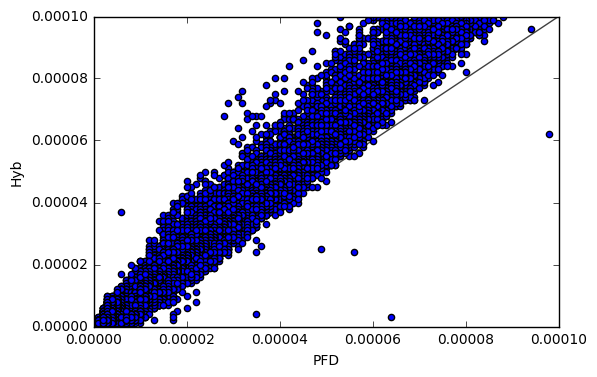

In [4]:
figure, ax = plt.subplots()

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.scatter(inputData['PFD'], inputData['Hyb'])
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlabel('PFD')
ax.set_ylabel('Hyb')
ax.set_xlim((0,0.0001))
ax.set_ylim((0,0.0001))

In [5]:
inputData['onesRatio'] = ((inputData['#Ones'] / inputData['DF']) * 100).round().astype("uint32")
inputData['winLoseRatio'] = inputData['Hyb'] / inputData['PFD']
print inputData["winLoseRatio"].mean()

0.924008556083


In [6]:
print inputData.columns

Index([u'TermNo', u'DF', u'#Ones', u'PFD', u'Hyb', u'Hyb_Disk', u'Hyb_PFD',
       u'Hyb_Bitarray', u'Hyb_Merge', u'onesRatio', u'winLoseRatio'],
      dtype='object')


In [7]:
# Por longitud de Lista, organizada en bins, análisis ganancia-perdida (Tabla) #

# Max Postings List Lenght: 13,059,642 #
# [0,10^3), [10^3,10^4), [10^4,10^5), [10^5,10^6), [10^6,10^7), [10^7,10^8) #
logBins = np.logspace(3.0, 8, num=6, dtype=np.uint64)
proportionBins = np.arange(10, 100, 10)
binCount_winLoseRatio_per_Li = np.zeros(6, dtype=np.uint64)
binCount_winLoseRatio_per_OnesRatio = np.zeros((6, 10), dtype=np.uint64)
mean_winLoseRatio_perLi = np.zeros(6, dtype=np.float64)
mean_winLoseRatio_per_OnesRatio = np.zeros((6, 10), dtype=np.float64)
# Interval Type [) #

print proportionBins
for row in inputData.values:
    Li_Len = row[1] # Longitud de la Lista (# de entradas - DF)
    indexLi = bisect.bisect_right(logBins, Li_Len)
    binCount_winLoseRatio_per_Li[indexLi] += 1
    mean_winLoseRatio_perLi[indexLi] += row[10]
    indexOnesRatio = bisect.bisect_right(proportionBins, row[9])
    binCount_winLoseRatio_per_OnesRatio[indexLi, indexOnesRatio] += 1
    mean_winLoseRatio_per_OnesRatio[indexLi, indexOnesRatio] += row[10]

#print bin_count
print mean_winLoseRatio_perLi.sum() / inputData.shape[0]
mean_winLoseRatio_perLi = mean_winLoseRatio_perLi / binCount_winLoseRatio_per_Li

[10 20 30 40 50 60 70 80 90]
0.924008556082


In [8]:
#np.seterr(invalid='ignore')
for i, row in enumerate(mean_winLoseRatio_per_OnesRatio):
    mean_winLoseRatio_per_OnesRatio[i] = np.nan_to_num(np.divide(row, binCount_winLoseRatio_per_OnesRatio[i]))

/home/esteban/virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [9]:
#Posting List Max Lenght
print "PLML Mean Win/Lose(Row)\t 10%\t20%\t30%\t40%\t50%\t60%\t70%\t80%\t90%"
for i, mean in enumerate(mean_winLoseRatio_perLi):
    sys.stdout.write("%i %.10f " % (mean_winLoseRatio_perLi[i], mean))
    for mean_row in mean_winLoseRatio_per_OnesRatio[i]:
        sys.stdout.write(" %.3f " % (mean_row))
    sys.stdout.write("\n")
#Ganacia/Perdida 

PLML Mean Win/Lose(Row)	 10%	20%	30%	40%	50%	60%	70%	80%	90%
0 0.8512306099  0.873  0.895  0.898  0.833  0.792  0.735  0.677  0.611  0.512  0.409 
1 1.1491815863  1.157  1.144  1.157  1.222  1.244  1.159  1.122  1.086  0.998  0.826 
1 1.3450770700  1.329  1.313  1.347  1.372  1.380  1.379  1.358  1.349  1.331  1.305 
1 1.5165734884  2.301  1.449  1.503  1.537  1.572  1.547  1.530  1.498  1.479  1.451 
1 1.6185293512  0.000  0.000  0.000  1.770  1.742  1.716  1.673  1.607  1.515  1.401 
1 1.5004893123  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.499  1.502 


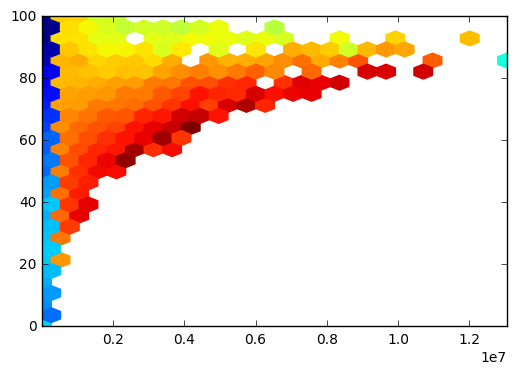

In [43]:
#print inputData.dtypes
onesOverListLenght = (inputData['#Ones'] / inputData['DF']) * 100
onesOverListLenght = onesOverListLenght.round().astype("uint32")
figure, ax = plt.subplots()

ax.hexbin(inputData['DF'], onesOverListLenght, winLoseRatio, gridsize=25)
plt.show()


In [45]:
proportionBins

[ 10  20  30  40  50  60  70  80  90 100]
